### Motivation: 
Given spreadsheet containing Building Description, Employee Type Description, First Name, Last Name, Street Address, City, State, Zip, Primary Phone, and Deduction Code, determine probability of membership by dataset example. 

## Import packages

In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split

## Load the data

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
Q12 = drive.CreateFile({'id':'1iO-G9Qh0aaNTljixoB0Jl5ErodzK9j72'}) 
Q12.GetContentFile('HBUnit.csv') 

In [5]:
# Load dataset
df_train = pd.read_csv('HBUnit.csv')
print(f'shape of data: {df_train.shape}')
# Display the first 5 rows
df_train.head(10)

shape of data: (1420, 8)


,Building Description,Employee Type Description,First Name,Last Name,Street Address,City/State/Zip,Primary Phone,Deduction Code
0,APH,BOOKKPR SCHOOL,MILDRED M,CARABALLO,2383 N CHARLINE RD,AVON PARK FL 33825-0000,(863) 214-3052,NaN
1,SHS,BOOKKPR SCHOOL,NATALIE O,GRUBB,2040 ALAN ST,SEBRING FL 33875-0000,(863) 385-5209,NaN
2,LPH,BOOKKPR SCHOOL,GAYLE RENE,SAMPERI,42 LK HENRY DR,LAKE PLACID FL 33852,(863) 699-1994,NaN
3,TRANSPORTATION,BUS ATTENDANT,LYSTRA,CALLAHAN,335 GLORIA BLVD,LAKE PLACID FL 33852-0000,(863) 243-3929,UHCS2
4,TRANSPORTATION,BUS ATTENDANT,IRVING,CRUZ CHAVEZ,112 IMBROS AVE NE,LAKE PLACID FL 33852,(863) 243-0618,NaN
5,TRANSPORTATION,BUS ATTENDANT,PATRICIA CLYDE,FLORY,1920 JERI KAY LN,SEBRING FL 33870,(863) 368-1557,UHCS2
6,TRANSPORTATION,BUS ATTENDANT,LUCINDA FAYE,FOSTER,3202 AVERY CT,SEBRING FL 33870-0000,(907) 888-0948,NaN
7,TRANSPORTATION,BUS ATTENDANT,BARBARA ELLEN,FRASER,1404 FERNVALE AVE,SEBRING FL 33870-0000,(863) 471-9984,NaN
8,TRANSPORTATION,BUS ATTENDANT,DOROTHY SAMARE MITCHELL,GRANT,1874 JONES DR,SEBRING FL 33870-0000,(863) 253-0819,UHCS2
9,TRANSPORTATION,BUS ATTENDANT,PATRICIA ANN,GROSS,3152 HOOVER AVE,LAKE PLACID FL 33852,(863) 465-7359,NaN


## Data Preprocessing / Wrangling

In [8]:
# place values of 'City/State/Zip' into a list
test = df_train['City/State/Zip'].values.tolist()
# split each item in the list by 'FL' and update df_train
df_train['City/State/Zip'] = [i.split('FL ', 1)[1] for i in test]
# split each item in the list by '-' and update df_train
df_train['City/State/Zip'] = [i.split('-',1)[0] for i in df_train['City/State/Zip']]
# rename 'City/State/Zip' to 'Zip'
df_train = df_train.rename(columns={'City/State/Zip': 'Zip'}) 

### Drop redundant features

In [9]:
# Drop columns 'First Name', 'Last Name', 'Street Address', 'Primary Phone'
df_train = df_train.drop(columns=['First Name', 'Last Name', 'Street Address', 'Primary Phone'])
print(f'new shape: {df_train.shape}')
print(f'Remaining Features: {df_train.columns.tolist()}')

new shape: (1420, 4)
Remaining Features: ['Building Description', 'Employee Type Description', 'Zip', 'Deduction Code']


### Find the non-numeric features

In [10]:
df_train.dtypes

Building Description         object
Employee Type Description    object
Zip                          object
Deduction Code               object
dtype: object

### Print the unique values of the non-numeric features

In [11]:
len(df_train['Building Description'].unique())

33

In [12]:
len(df_train['Employee Type Description'].unique())

42

In [13]:
len(df_train['Zip'].unique())

31

In [14]:
df_train['Deduction Code'].unique()

array([nan, 'UHCS2', 'UHCS1', 'UHCEA'], dtype=object)

### Assign numerical mappings to deduction codes and replace NaNs with 0s

In [15]:
binary_columns = ['Deduction Code']
# Create a dictionary in which the keys map to the values
# Remember, we want to replace 'no' and 'yes' with the appropriate integers
binary_mapping = {'UHCS1': 1.0, 'UHCEA': 1.0, 'UHCS2': 1.0}
# Map the binary columns
for col in binary_columns:
    # Apply the mapping to the current column with the map() method for Pandas Series
    df_train[col] = df_train[col].map(binary_mapping)
    # Fill NaN values with 0
    df_train[col] = df_train[col].fillna(0)


### Replace categorical features with numerical features




In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoder = LabelEncoder()

building_labels = encoder.fit_transform(df_train['Building Description'])
df_train['Building Description'] = building_labels

employee_labels = encoder.fit_transform(df_train['Employee Type Description'])
df_train['Employee Type Description'] = employee_labels

zip_labels = encoder.fit_transform(df_train['Zip'])
df_train['Zip'] = zip_labels

### Inspect how balanced y is
For a balanced binary target, approximately half of its entries will be 1

In [17]:
y = df_train['Deduction Code']
fraction = y.value_counts()[1] / y.value_counts()[0]
print('proportion of positive values: %.3f ' % (fraction))

proportion of positive values: 0.573 


Task 1: To find the optimal set of features for this data set. Visualize each feature's contribution to separate Non_member=0 from Member=1, and select the top two features (for scatter plot)

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
print(f'The training data currently has {df_train.shape[1]} features')

The training data currently has 4 features


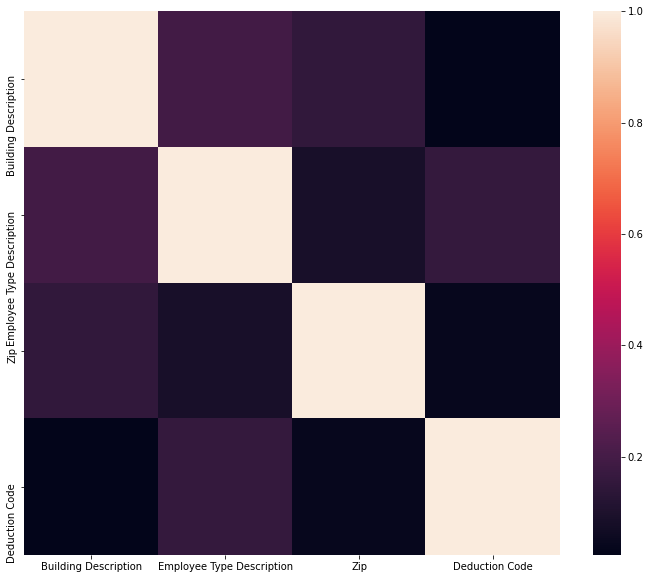

In [19]:
#Visual inspection of features
plt.figure(figsize=(12,10))
### START CODE HERE ###
# Compute the Pearson Correlation of each feature in the training df
cor = df_train.corr()
### END CODE HERE ###
# Plot the correlations
sns.heatmap(cor.abs())
plt.show()
# Some intersting correlations pop up that need further analysis (later)
# we need to eliminate features that have very high absolute correlations

### Drop features with high correlations

In [20]:
### START CODE HERE ###
# Initialize a list indicating whether to keep a column in the training df
# For now, set all entries to True
keep_columns = np.full((cor.shape[0],), True, dtype=bool)
# Loop over all columns
for i in range(cor.shape[0]-1):
    # Loop over all columns to the right of the current one
    for j in range(i+1, cor.shape[0]-1):
        # If the absolute correlation between the current two columns is greater than or equal to 0.8, or no correlation 0 value...
        if (np.abs(cor.iloc[i,j]) >= 0.8):
            # If we haven't already told the keep_columns list to drop column j...
            if keep_columns[j]:
                # Drop column j
                keep_columns[j] = False
# Extract the columns to keep from the training df
selected_columns = df_train.columns[keep_columns]
# Make a new df with the columns we've decided to keep from the training df
X_out = df_train[selected_columns]
### END CODE HERE ###
print('The following columns are present in the new data:')
print(selected_columns)
print(f'The old data had {df_train.shape[1]} features. The new df has {X_out.shape[1]} features.')
print(df_train.shape)
X_out.head()

The following columns are present in the new data:
Index(['Building Description', 'Employee Type Description', 'Zip',
       'Deduction Code'],
      dtype='object')
The old data had 4 features. The new df has 4 features.
(1420, 4)


,Building Description,Employee Type Description,Zip,Deduction Code
0,2,0,3,0.0
1,26,0,17,0.0
2,18,0,9,0.0
3,30,1,9,1.0
4,30,1,9,0.0


## Feature Selection on p-value (statistical significance to Y value) 

In [21]:
selected_columns = selected_columns[0:]
import statsmodels.api as sm
def backwardElimination(x, y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        #maxVar = max(regressor_OLS.pvalues).astype(float)
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.01
# Note that we're passing in df_out, not df_train
data_modeled, selected_columns = backwardElimination(X_out.values, y, SL, selected_columns)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [22]:
print('The following columns remain based on p-value selection:')
print(selected_columns)
# Make a reduced df
data_red = pd.DataFrame(data = data_modeled, columns = selected_columns)
print(f'After selection by Pearson Correlation, we had {X_out.shape[1]} features.')
print(f'After selection by p-value, we have {data_red.shape[1]} features.')

The following columns remain based on p-value selection:
Index(['Building Description', 'Employee Type Description', 'Deduction Code'], dtype='object')
After selection by Pearson Correlation, we had 4 features.
After selection by p-value, we have 3 features.


### Visualize the selected features

Ignore the warning messages about distplot. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

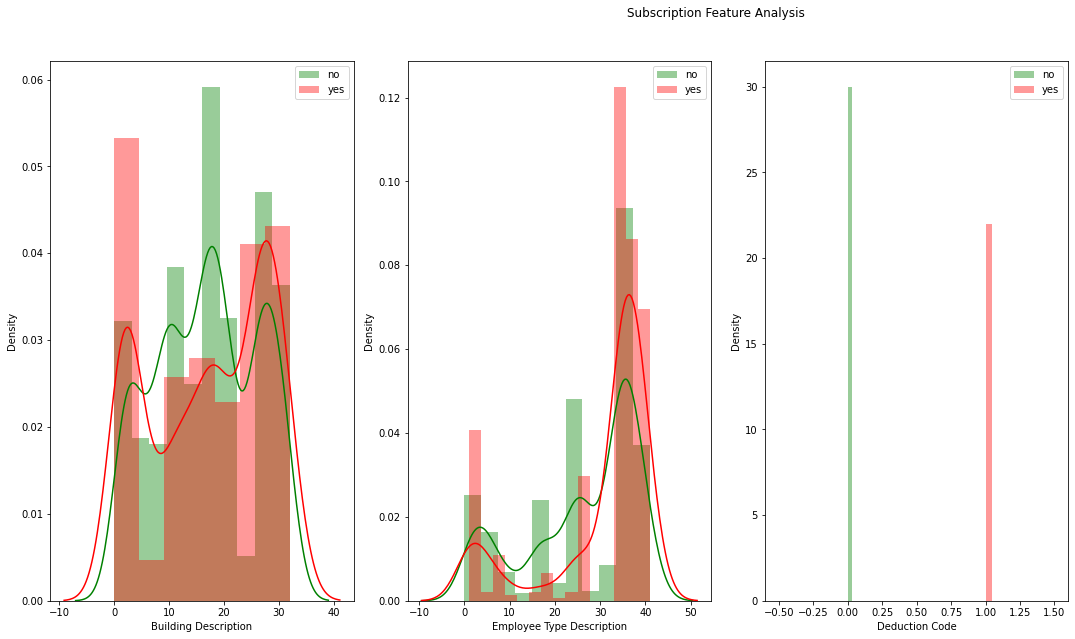

In [23]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_red.columns:
    plt.subplot(3, 4, j+1)
    j += 1
    sns.distplot(data_red[i][data_red['Deduction Code']==0], color='g', label = 'no')
    sns.distplot(data_red[i][data_red['Deduction Code']==1], color='r', label = 'yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Drop deduction code from the features of X_train and scale the features so the max norm of each feature is 1. Also, convert the X DataFrames and y Series to NumPy arrays for use with the visualization convenience function which we'll set up next.

In [24]:
from sklearn.preprocessing import normalize
X_train = data_red.drop(columns='Deduction Code')
X_train = normalize(X_train, axis=0, norm='max')
y_train = df_train['Deduction Code'].values

In [25]:
indices = np.arange(df_train.shape[0])
X_train, X_test, y_train, y_test, idx1, idx2 = train_test_split(X_train, y, indices, test_size=0.33)
print(X_train.shape)
print(X_test.shape)

(951, 2)
(469, 2)


Feature ranking:
1. feature 1 (0.609430)
2. feature 0 (0.390570)


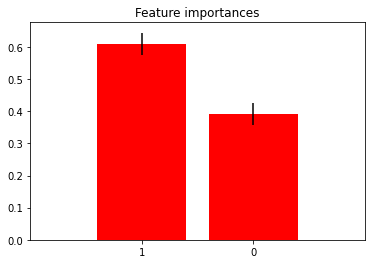

In [26]:
#Use Random Forest to get feature ranks/importances for each feature
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [27]:
# This function visualizes the classification output on scatter plot
# Feature 1 (Interaction Time is used to observe the impact of low ranked feature)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
def visualize_scatter_plot(X, y, yhat, title):
    loc11=np.where((y>0) & (yhat>0),1,0) #TP
    loc00=np.where((y==0) & (yhat==0),1,0) #TN
    loc10=np.where((y>0) & (yhat==0),1,0) #FN
    loc01=np.where((y==0) & (yhat>0),1,0) #FP
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(X[np.where(loc00>0),3],X[np.where(loc00>0),4],X[np.where(loc00>0),1],color='blue', marker='o')
    ax.scatter3D(X[np.where(loc10>0),3],X[np.where(loc10>0),4],X[np.where(loc10>0),1],color='cyan', marker='o')
    ax.scatter3D(X[np.where(loc11>0),3],X[np.where(loc11>0),4],X[np.where(loc11>0),1],color='red', marker='^')
    ax.scatter3D(X[np.where(loc01>0),3],X[np.where(loc01>0),4],X[np.where(loc01>0),1],color='green', marker='^')
    ax.set_xlabel('NumCart')
    ax.set_ylabel('NumViews')
    ax.set_zlabel('InteractionTime')
    plt.title(title)
    plt.show()

## Task 2. Fit a linear model. Pick from SVM, LR. Report results
Ensure each model is the fitted with the best hyperparameters. That includes mitigating the effects of any class imbalances.

### Import models, metrics, and convenience functions


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

### Instantiate, train, and predict with the model (Logistic Regression)

In [29]:
regb = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)
reg_predb = regb.predict(X_test)

#### Evaluate the predictions

In [30]:
cmlog = confusion_matrix(y_test, reg_predb)
acc   = accuracy(y_test, reg_predb)
rec   = recall(y_test, reg_predb)
prec  = precision(y_test, reg_predb)
f1    = f1_score(y_test, reg_predb)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmlog)

Accuracy = 0.5437100213219617, Precision = 0.4357142857142857, Recall = 0.6853932584269663, F1-score = 0.5327510917030569
Confusion Matrix is:
[[133 158]
 [ 56 122]]


In [31]:
# Fine-tuning (Logistic Regression) 
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'penalty': ['l2'] , 'C': [0.01,0.1,0.5,1,3]}
              ]

grid_search = GridSearchCV(regb, param_grid, cv=5, scoring='neg_mean_squared_error') 

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 0.5, 1, 3], 'penalty': ['l2']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [32]:
# Cross Validation (Logistic Regression w/ tuned parameters)
from sklearn.model_selection import cross_val_score as cvs
scores = cvs(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
regb_rmse_scores = np.sqrt(-scores)  

In [33]:
def display_scores(scores): 
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(regb_rmse_scores)

Scores: [0.66926577 0.71081865 0.59824304 0.64888568 0.68055705 0.65694669
 0.64072328 0.64072328 0.69585237 0.64888568]
Mean: 0.6590901488498513
Standard deviation: 0.030301124487734563


In [34]:
# View Updated Metrics
reg_predb = grid_search.best_estimator_.predict(X_test)
cmlog = confusion_matrix(y_test, reg_predb)
acc   = accuracy(y_test, reg_predb)
rec   = recall(y_test, reg_predb)
prec  = precision(y_test, reg_predb)
f1    = f1_score(y_test, reg_predb)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmlog)
#No improvement

Accuracy = 0.5522388059701493, Precision = 0.445578231292517, Recall = 0.7359550561797753, F1-score = 0.5550847457627118
Confusion Matrix is:
[[128 163]
 [ 47 131]]


In [35]:
### START CODE HERE ###
# Next Run SVM with class weight balanced
svmm = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class='ovr'))
svmm.fit(X_train, y_train)
### END CODE HERE ###

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=0,
                           tol=0.01, verbose=0))],
         verbose=False)

In [36]:
### START CODE HERE ###
svm_predb = svmm.predict(X_test)
cms  = confusion_matrix(y_test, svm_predb)
acc  = accuracy(y_test, svm_predb)
rec  = recall(y_test, svm_predb)
prec = precision(y_test, svm_predb)
f1   = f1_score(y_test, svm_predb)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cms)

Accuracy = 0.5437100213219617, Precision = 0.4357142857142857, Recall = 0.6853932584269663, F1-score = 0.5327510917030569
Confusion Matrix is:
[[133 158]
 [ 56 122]]


In [37]:
svm_predb = svmm.predict(X_test)
svm_predb = svm_predb.reshape(469,1)

#### Append predictions to original spreadsheet

In [41]:
df = pd.read_csv('HBUnit.csv')
df = df.iloc[idx2]

df['predicted'] = svm_predb
df['actual'] = df_train['Deduction Code'][idx2]

# Rearrange column order
col = ['Building Description',
  'First Name',
  'Last Name',
  'Street Address',
  'City/State/Zip',
  'actual',
  'predicted']
df = df[col]
df.iloc[np.where(df['actual'] != df['predicted'])]

,Building Description,First Name,Last Name,Street Address,City/State/Zip,actual,predicted
907,FWE,COURTNEY MICHELLE,MURFIELD,237 GREENSVIEW DR,AVON PARK FL 33825-0000,0.0,1.0
379,TRANSPORTATION,JOSEPH WILLIAM,POWERS,1107 HIGHLAND DR,SEBRING FL 33870-0000,0.0,1.0
710,LCE,MELISSA LYNNE THOMAS,MCCRARY,112 EVENTIDE AVE,LAKE PLACID FL 33852,0.0,1.0
1046,SHS,WENDY M,BAUER,2850 PETERS RD,SEBRING FL 33870-0000,0.0,1.0
1125,SHS,DETRICE J,MENCHAN,2439 W NAUTILUS RD,AVON PARK FL 33825-0000,0.0,1.0
...,...,...,...,...,...,...,...
776,WES,LAURA FRANCES,TENNESON,4009 HEDGE AVE,SEBRING FL 33875-0000,0.0,1.0
1247,LPM,ALICIA LYNN,VEGA,619 HILL RD,LAKE PLACID FL 33852-0000,0.0,1.0
1399,MIS,PAMELA A,LIESKE,512 SPORTSMAN AVE,SEBRING FL 33875-0000,0.0,1.0
583,SMS,WANDA E,JIMENEZ,4300 SHAD DR,SEBRING FL 33870-0000,0.0,1.0
